In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "Rib_Rib_HCLFetalRib3"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.txt.gz"),h = T,sep=',',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 6)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.csv"), h = T, sep = ",", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [5]:
nrow(data.metadata)
ncol(data.matrix)

[1] 4560

[1] 4560

Warning message in CreateSeuratObject(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix.”


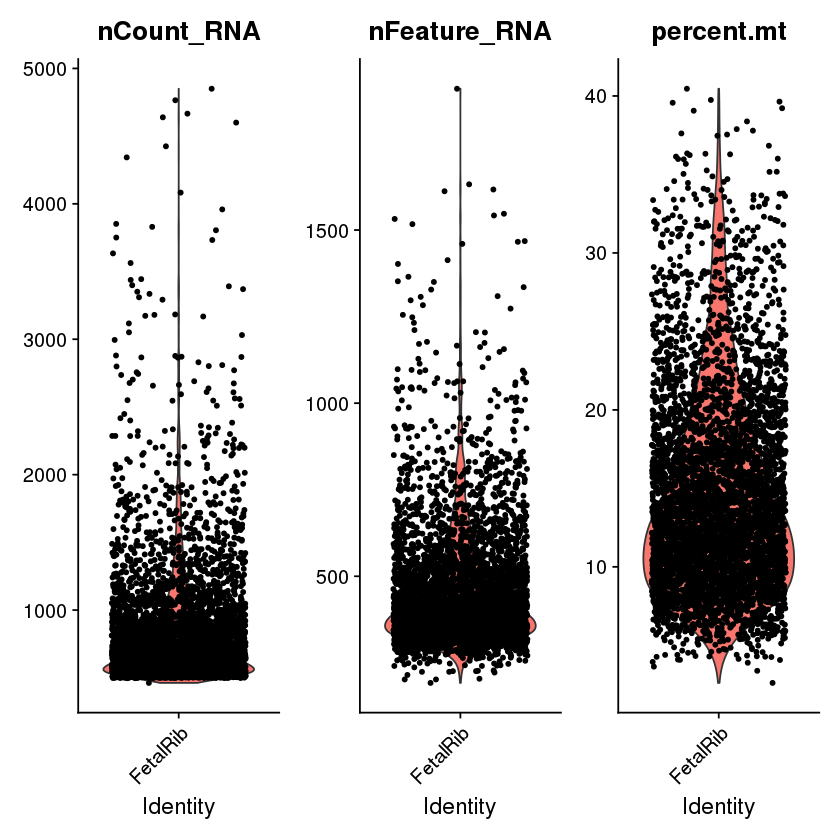

In [6]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [7]:
percent.mt.thre = 40
nFeature_RNA_range = c(min.features, 1000)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [8]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [9]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 15219  4480
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A2M"   "AAAS"  "AACS"  "AADAT" "AAED1"
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 13703  4480
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  4480
[1] "Finished"


In [10]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  EPYC, HAPLN1, CNMD, S100A1, GAPDH, S100A10, SNORC, SCRG1, CLEC3A, FGFBP2 
	   LDHA, PGK1, ANXA2, ENO1, ITM2A, BNIP3, S100A13, C1QTNF3, COL9A1, PDPN 
	   MATN1, MIA, FAM162A, SEC61G, PPIB, TPI1, UGP2, YWHAQ, TSC22D1, PANX3 
Negative:  COL1A2, COL1A1, TMSB4X, COL3A1, COL5A2, OGN, S100A4, POSTN, DCN, FOS 
	   SERPINF1, COL4A1, IBSP, CCL2, GNG11, IGFBP5, SPARCL1, ASPN, COL12A1, LGALS1 
	   ANXA1, OMD, TYROBP, FCER1G, CXCL12, SPRY1, IGFBP7, NRP1, THBS4, AIF1 
PC_ 2 
Positive:  COL9A1, CNMD, DLK1, UCMA, COL11A1, EPYC, MATN1, ECRG4, S100B, COL11A2 
	   ITM2A, FMOD, CYTL1, COL9A3, MIA, COL9A2, MEST, HAPLN1, COL14A1, FOSB 
	   CCN1, MATN3, DCN, FN1, NID2, EDIL3, CPE, THBS1, SNAI2, PEG3 
Negative:  S100A4, TYROBP, FCER1G, TMSB10, ACP5, GPR183, MMP9, TMSB4X, RGS10, CD74 
	   CKB, SRGN, CSTB, HLA-DRA, ATP6V0E1, AIF1, ANXA1, CST3, LGALS1, GMFG 
	   CXCL8, LYZ, CA2, RGS1, RETN, ATP5F1E, ATP5MF, UQCRQ, NPC2, ATP5MC3 
PC_ 3 
Positive:  FGFBP2, PANX3, CLEC3A, CA2, A2M, SCRG1, OST4, SP

png 
  2

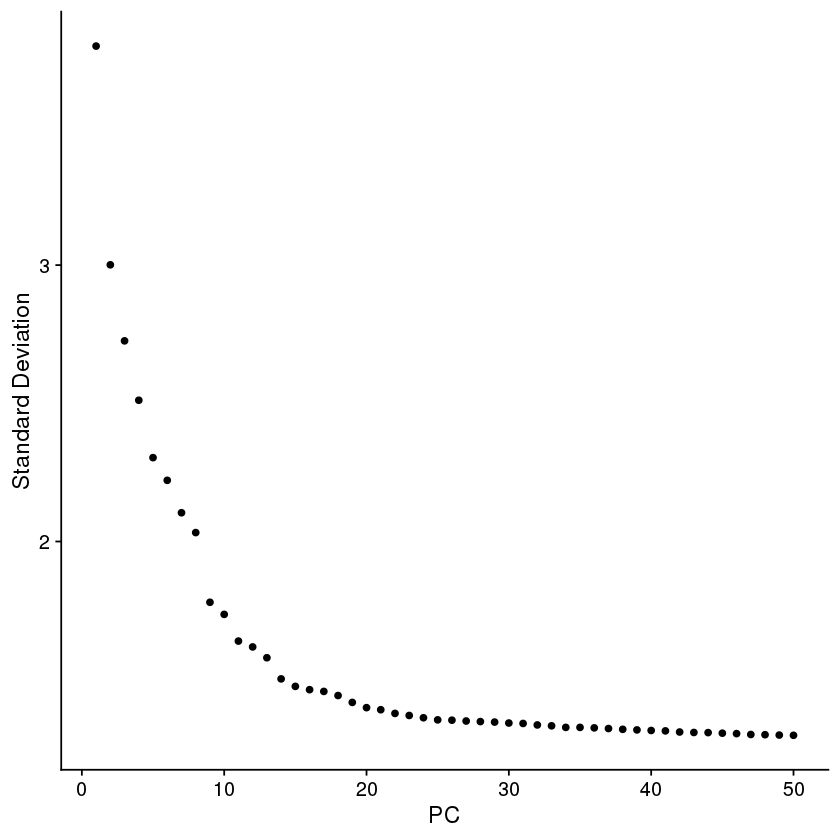

In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [12]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [13]:
dataobj$cell_cluster <- dataobj$CT

In [14]:
dataobj <- FindClusters(dataobj, resolution = 0.6, n.start = 5)
randIndex(dataobj$CT,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4480
Number of edges: 169598

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.7743
Number of communities: 10
Elapsed time: 0 seconds


ARI 
0.434847

In [15]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:23:56 UMAP embedding parameters a = 0.9922 b = 1.112

15:23:56 Read 4480 rows and found 30 numeric columns

15:23:56 Using Annoy for neighbor search, n_neighbors = 30

15:23:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:23:57 Writing NN index file to temp file /tmp/RtmpuF4j3W/file646e2cb558d2

15:23:57 Searching Annoy index using 1 thread, search_k = 3000

15:23:59 Annoy recall = 100%

15:23:59 Commencing smooth kNN distance calibration using 1 thread

15:24:00 Initializing fr

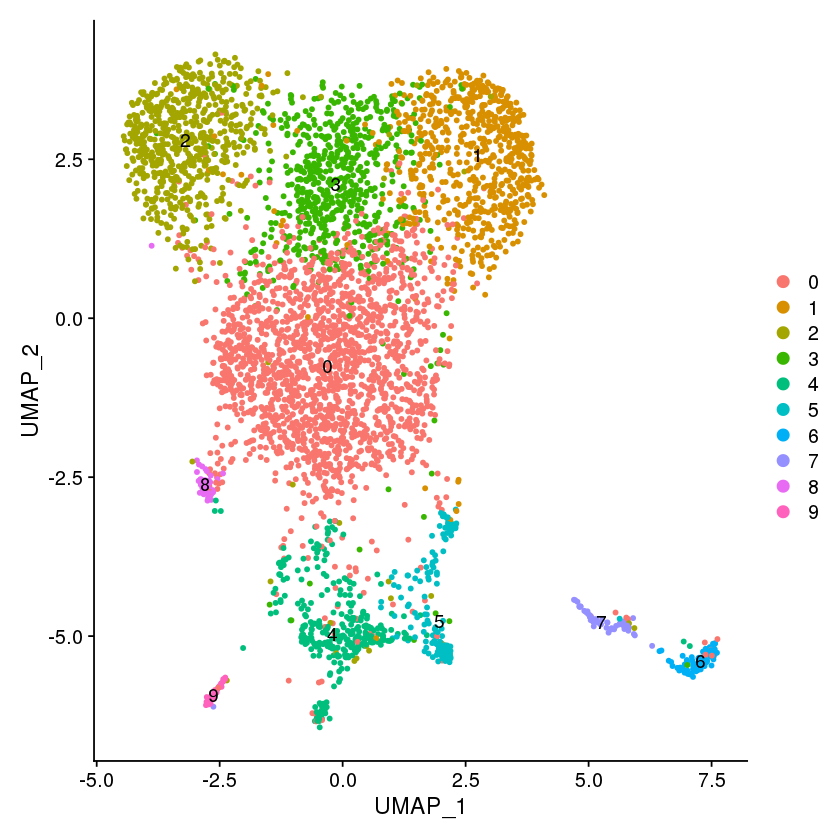

In [16]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

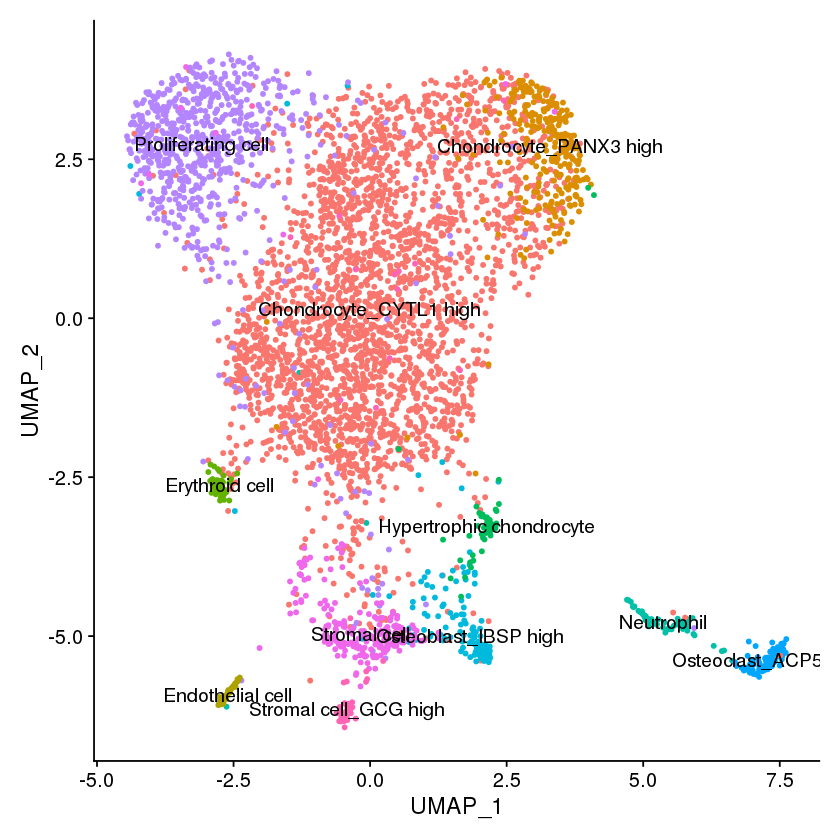

In [17]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [20]:
unique(dataobj$cell_cluster)

[1] Neutrophil               Osteoclast_ACP5 high     Chondrocyte_CYTL1 high  
 [4] Osteoblast_IBSP high     Chondrocyte_PANX3 high   Proliferating cell      
 [7] Erythroid cell           Stromal cell             Stromal cell_GCG high   
[10] Hypertrophic chondrocyte Endothelial cell        
11 Levels: Chondrocyte_CYTL1 high Chondrocyte_PANX3 high ... Stromal cell_GCG high

In [32]:
new.cluster.ids <- c("Rib-Connective tissue-Chondrocyte-COL2A1 MGP", 
                     "Rib-Connective tissue-Chondrocyte-COL2A1 MGP",
                     "Rib-Connective tissue-T cell-HMGB2 TUBA1B",
                     "Rib-Connective tissue-Chondrocyte-COL2A1 MGP",
                     "Rib-Connective tissue-Fibroblast-COL1A1 COL3A1",
                     "Rib-Connective tissue-Osteoclast-IBSP",
                     "Rib-Connective tissue-Osteoclast-MMP9",
                     "Rib-Connective tissue-Neutrophilic granulocyte-RETN IL1B",
                     "Rib-Connective tissue-Erythrocyte-ALAS2",
                     "Rib-Epithelial tissue-Endothelial cell-APLNR"
                    )

In [10]:
subset(dataobj.markers,cluster=='Unclassified')
# subset(dataobj.markers,gene=='NUPR1')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
HMGB21,0.000000e+00,2.0028542,0.811,0.158,0.000000e+00,Unclassified,HMGB2
STMN1,7.271522e-279,1.7137076,0.883,0.286,3.190598e-274,Unclassified,STMN1
CDK1,1.976924e-273,1.9129599,0.460,0.030,8.674349e-269,Unclassified,CDK1
UBE2C,4.150188e-256,1.8430721,0.447,0.032,1.821020e-251,Unclassified,UBE2C
TUBA1B,2.609577e-212,1.4973206,0.834,0.317,1.145030e-207,Unclassified,TUBA1B
NUSAP1,1.003871e-183,1.5779265,0.339,0.026,4.404785e-179,Unclassified,NUSAP1
H2AZ11,1.987512e-182,1.2730698,0.855,0.386,8.720805e-178,Unclassified,H2AZ1
UBE2T,5.415800e-169,1.5484175,0.352,0.035,2.376345e-164,Unclassified,UBE2T
PTTG1,9.883011e-169,1.5144462,0.630,0.170,4.336468e-164,Unclassified,PTTG1


In [34]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [35]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

15:33:42 UMAP embedding parameters a = 0.9922 b = 1.112

15:33:42 Read 4480 rows and found 30 numeric columns

15:33:42 Using Annoy for neighbor search, n_neighbors = 30

15:33:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:33:43 Writing NN index file to temp file /tmp/RtmpuF4j3W/file646e1616ec71

15:33:43 Searching Annoy index using 1 thread, search_k = 3000

15:33:45 Annoy recall = 100%

15:33:46 Commencing smooth kNN distance calibration using 1 thread

15:33:47 Initializing from normalized Laplacian + noise

15:33:47 Commencing optimization for 500 epochs, with 188858 positive edges

15:34:03 Optimization finished



In [ ]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [7]:
dataobj$hcadv1name = dataobj.dbupload_v1$hcad_name
Idents(dataobj) = dataobj$hcadv1name

In [ ]:
UMAPPlot(dataobj,label = T, pt.size=1,label.size=5)+NoLegend()

In [9]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster Rib-Connective tissue-Neutrophil-RETN IL1B

Calculating cluster Rib-Connective tissue-Osteoclast-MMP9

Calculating cluster Rib-Connective tissue-Chondrocyte-COL2A1 MGP

Calculating cluster Unclassified

Calculating cluster Rib-Connective tissue-Osteoclast-IBSP

Calculating cluster Rib-Connective tissue-Fibroblast-COL1A1 COL3A1

Calculating cluster Rib-Connective tissue-Erythroid cell-ALAS2

Calculating cluster Rib-Epithelial tissue-Endothelial cell-APLNR



In [21]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(dataobj$seurat_clusters),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [37]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [38]:
dataobj

An object of class Seurat 
43878 features across 4480 samples within 1 assay 
Active assay: RNA (43878 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [39]:
# ncol(result_data_out
print(levels(dataobj$sample_status))
levels(dataobj$donor_age)    

NULL


[1] "13W"

In [40]:
levels(dataobj$donor_age) <- c('GW13')

In [41]:
levels(dataobj$organ)
levels(dataobj$region)
levels(dataobj$subregion)

[1] "FetalRib3"

NULL

NULL

In [42]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Rib"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-"NA"
dataobj.dbupload_v1$donor_gender<-"Male"
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [43]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [6]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [45]:
ncol(dataobj.dbupload_v1@meta.data)
colnames(dataobj.dbupload_v1@meta.data)

[1] 14

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subregion"     "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [46]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 4480 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [47]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalRib_3.AACCTACCTAGATCGTAA,1,10.1038/s41586-020-2157-4,FetalRib_3.AACCTACCTAGATCGTAA,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,NA,Neutrophil,NA,Rib-Connective tissue-Neutrophil-RETN IL1B
FetalRib_3.AGCGAGATACAGGCAGGA,1,10.1038/s41586-020-2157-4,FetalRib_3.AGCGAGATACAGGCAGGA,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,NA,Neutrophil,NA,Rib-Connective tissue-Neutrophil-RETN IL1B
FetalRib_3.CGAGTAAAAGTTAGCGAG,1,10.1038/s41586-020-2157-4,FetalRib_3.CGAGTAAAAGTTAGCGAG,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,NA,Neutrophil,NA,Rib-Connective tissue-Neutrophil-RETN IL1B


In [32]:
dataobj.dbupload_v1$donor_age <- "GW13"

In [3]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [6]:
dataobj<- readRDS(file = paste0(datasetName,".seuratobj.rds"))

In [4]:
hname <-  as.factor(dataobj.dbupload_v1$original_name)
levels(hname)

[1] "Chondrocyte_CYTL1 high"   "Chondrocyte_PANX3 high"  
 [3] "Endothelial cell"         "Erythroid cell"          
 [5] "Hypertrophic chondrocyte" "Neutrophil"              
 [7] "Osteoblast_IBSP high"     "Osteoclast_ACP5 high"    
 [9] "Proliferating cell"       "Stromal cell"            
[11] "Stromal cell_GCG high"

In [5]:
levels(hname) <- c("Rib-Connective tissue-Chondrocyte",
                   "Rib-Connective tissue-Chondrocyte",
                   "Rib-Epithelial tissue-Endothelial cell",
                   "Rib-Connective tissue-Erythroid cell",
                   "Rib-Connective tissue-Hypertrophic chondrocyte",
                   "Rib-Connective tissue-Neutrophil",
                   "Rib-Connective tissue-Osteoblast",
                   "Rib-Connective tissue-Osteoblast",
                   "Rib-Proliferating cell",
                   "Rib-Connective tissue-Stromal cell",  
                   "Rib-Connective tissue-Stromal cell")              

In [6]:
dataobj.dbupload_v1$hcad_name <- hname
dataobj.dbupload_v1$hcad_name <- as.character(dataobj.dbupload_v1$hcad_name)

In [7]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalRib_3.AACCTACCTAGATCGTAA,1,10.1038/s41586-020-2157-4,FetalRib_3.AACCTACCTAGATCGTAA,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,GW13,Neutrophil,NA,Rib-Connective tissue-Neutrophil
FetalRib_3.AGCGAGATACAGGCAGGA,1,10.1038/s41586-020-2157-4,FetalRib_3.AGCGAGATACAGGCAGGA,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,GW13,Neutrophil,NA,Rib-Connective tissue-Neutrophil
FetalRib_3.CGAGTAAAAGTTAGCGAG,1,10.1038/s41586-020-2157-4,FetalRib_3.CGAGTAAAAGTTAGCGAG,Rib,NA,NA,Microwell-seq,Healthy,NA,Male,GW13,Neutrophil,NA,Rib-Connective tissue-Neutrophil


In [3]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [5]:
dataobj.dbupload_v1$hcad_name<- sub("Rib-Proliferating cell-HMGB2","Unknown",dataobj.dbupload_v1$hcad_name)